#[COE 197-Z] Project 1: Heart Disease Prediction Model

**Changelog**


*   [3:44 AM, 3-13-19] Train: 86.67%, Test: 84.44%, Drivendata Score: 0.3420, Leaderboard Rank :103
*   note: adding batchnorm + dropout increases accuracy but makes log loss error higher because model makes less confident predictions. This tanks the ranking even though you have a more accurate model. 




**Preprocess Data using Pandas**

Note: Since I have zero background on preprocessing tabular data, the following was used as the main reference for this section: 
[Preprocessing Tabular Data](https://github.com/AnneDeGraaf/DrivenData_WarmUp_HeartDisease/blob/master/data_processing.py?fbclid=IwAR3Spxx1yyaRRpyO2yPeajdlv3SgcWuy-9ZwPLW5SPTWNIpzr0TFtph5h38)
Credits to  .[AnneDeGraaf](https://github.com/AnneDeGraaf/)

In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

train_url = 'https://raw.githubusercontent.com/henritomas/CoE197-Z-Tomas-DL-Experiments/master/train_values.csv'
test_url = 'https://raw.githubusercontent.com/henritomas/CoE197-Z-Tomas-DL-Experiments/master/test_values.csv'
rawTrain = pd.read_csv(train_url)
rawTest = pd.read_csv(test_url)

# change categorical data into one-hot:
trainSlope_oneHot = pd.get_dummies(rawTrain['slope_of_peak_exercise_st_segment'], prefix='slope')
trainThal_oneHot = pd.get_dummies(rawTrain['thal'])
trainChestPain_oneHot = pd.get_dummies(rawTrain['chest_pain_type'], prefix='chestPain')
trainResting_oneHot = pd.get_dummies(rawTrain['resting_ekg_results'], prefix='restingEkg')
testSlope_oneHot = pd.get_dummies(rawTest['slope_of_peak_exercise_st_segment'], prefix='slope')
testThal_oneHot = pd.get_dummies(rawTest['thal'])
testChestPain_oneHot = pd.get_dummies(rawTest['chest_pain_type'], prefix='chestPain')
testResting_oneHot = pd.get_dummies(rawTest['resting_ekg_results'], prefix='restingEkg')

# replace categorical columns by one-hot
rawTrain.drop(['slope_of_peak_exercise_st_segment','thal','chest_pain_type','resting_ekg_results'], axis=1, inplace=True)
rawTrain = rawTrain.join([trainSlope_oneHot, trainThal_oneHot, trainChestPain_oneHot, trainResting_oneHot])
rawTest.drop(['slope_of_peak_exercise_st_segment','thal','chest_pain_type','resting_ekg_results'], axis=1, inplace=True)
rawTest = rawTest.join([testSlope_oneHot, testThal_oneHot, testChestPain_oneHot, testResting_oneHot])

# check for NaN's in dataset
print(rawTrain.isnull().values.any())
print(rawTest.isnull().values.any())

# apply normalization to numerical data
numCols = ['resting_blood_pressure', 'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'age', 'max_heart_rate_achieved']
for col in numCols:
	rawTest[col] = (rawTest[col] - rawTrain[col].mean()) / rawTrain[col].std()
	rawTrain[col] = (rawTrain[col] - rawTrain[col].mean()) / rawTrain[col].std()
	print(rawTrain[col].mean(), rawTrain[col].std()) # should be 0 and 1

# Storing processed data into new file
rawTrain.to_csv('../train_values_normalized.csv')
rawTest.to_csv('../test_values_normalized.csv')

False
False
4.354541418807558e-16 1.0
4.502571155424246e-17 1.0
6.1679056923619804e-18 0.9999999999999992
1.0986582014519779e-16 0.9999999999999994
5.896517841898053e-16 1.0000000000000004


**Deep Learning Model Proper**

(180, 22)
(180, 2)
Train on 90 samples, validate on 90 samples
Epoch 1/500
90/90 [==============================] - 13s 149ms/step - loss: 0.7102 - acc: 0.5000 - val_loss: 0.6909 - val_acc: 0.5667
Epoch 2/500
90/90 [==============================] - 0s 390us/step - loss: 0.7083 - acc: 0.5111 - val_loss: 0.6899 - val_acc: 0.5778
Epoch 3/500
90/90 [==============================] - 0s 329us/step - loss: 0.7065 - acc: 0.5111 - val_loss: 0.6889 - val_acc: 0.5778
Epoch 4/500
90/90 [==============================] - 0s 334us/step - loss: 0.7050 - acc: 0.5222 - val_loss: 0.6879 - val_acc: 0.5778
Epoch 5/500
90/90 [==============================] - 0s 323us/step - loss: 0.7032 - acc: 0.5222 - val_loss: 0.6869 - val_acc: 0.5778
Epoch 6/500
90/90 [==============================] - 0s 333us/step - loss: 0.7016 - acc: 0.5333 - val_loss: 0.6859 - val_acc: 0.5778
Epoch 7/500
90/90 [==============================] - 0s 454us/step - loss: 0.6998 - acc: 0.5444 - val_loss: 0.6849 - val_acc: 0.5889
Epoch

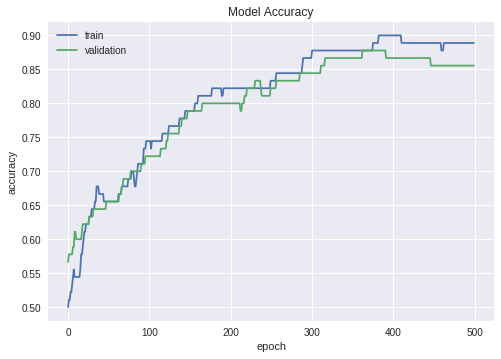

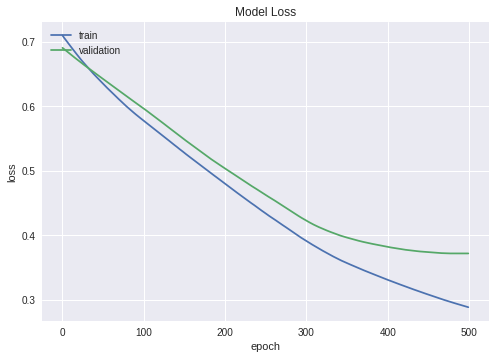

In [0]:
#Load pre-processed/ normalized data, mark column 0 as the index (patiend id)
train_labels_url = 'https://raw.githubusercontent.com/henritomas/CoE197-Z-Tomas-DL-Experiments/master/train_labels.csv'
x_train = pd.read_csv('../train_values_normalized.csv', index_col=0)
y_train = pd.read_csv(train_labels_url, index_col=0)

#Reshape/Format data
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train)
x_train = x_train.drop('patient_id',1) #Drops/deletes patient_id column

print(x_train.shape)
print(y_train.shape)

x_train, x_valid, y_train, y_valid = train_test_split(x_train, 
                                                      y_train, 
                                                      test_size=0.5)
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)

#Network Parameters
input_dim = (x_train.shape[1],) #required to be a tuple
batch_size = 32
epochs = 500

kreg = l2(0.0001)

#Build Model
inputs = Input(shape=input_dim)
y = Dense(15,
          input_dim=input_dim,
          activation='relu',
          kernel_regularizer=kreg)(inputs)
y = Dense(15,
          input_dim=input_dim,
          activation='relu',
          kernel_regularizer=kreg)(y)
outputs = Dense(num_labels, activation='softmax',
               kernel_regularizer=kreg)(y)
opt = Adam(lr=0.0001, 
           beta_1=0.9, 
           beta_2=0.999, 
           epsilon=1e-7, 
           decay=0.0, 
           amsgrad=False)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#Train Model
history = model.fit(x_train, y_train,
                    validation_data=(x_valid, y_valid),
                    epochs=epochs,
                    batch_size=batch_size)
"""
Accuracy is printed out, but for loss='***_crossentropy' log loss is
also printed out by default (loss/val_loss)
"""

#Final Accuracy on Test Data Set
scores = model.evaluate(x_valid, y_valid, batch_size=batch_size)
print("\nTest Accuracy: %.2f%%" % (100.0 * scores[1])) 

#Plot validation vs training accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Plot validation vs training loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
fin_test = pd.read_csv('../test_values_normalized.csv', index_col=0)
xfin_test = fin_test.drop('patient_id',1) #Drops/deletes patient_id column

fin_proba = model.predict(xfin_test,verbose=1)
bin_proba = [prob[1] for prob in fin_proba]
submission = pd.DataFrame({'patient_id': fin_test.patient_id.values, 
                           'heart_disease_present': bin_proba})
submission = submission[['patient_id', 'heart_disease_present']]
submission.to_csv("my_submission.csv", index=False)

90/90 [==============================] - 3s 34ms/step
